In [2]:
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import matplotlib
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
BASE_PATH = 'style_transfer_bk'

sources = [
    {
        "subject": "forest.jpg",
        "style": "metropolis.jpg"
    },
    
]

base_image_path = sources[0]["subject"]
style_reference_image_path = sources[0]["style"]

iterations = 600
# Weights of the different cost function components
total_variation_weight = 1e-6
style_weight = 3e-6
content_weight = 5e-6

# Dimensions of the generated images
width, height = tf.keras.preprocessing.image.load_img(os.path.join(BASE_PATH, base_image_path)).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

style_transfer_bk\forest.jpg


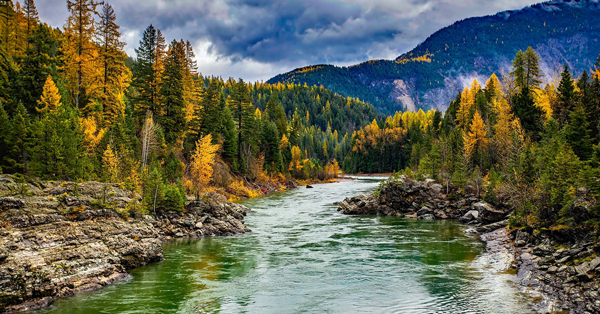



style_transfer_bk\metropolis.jpg


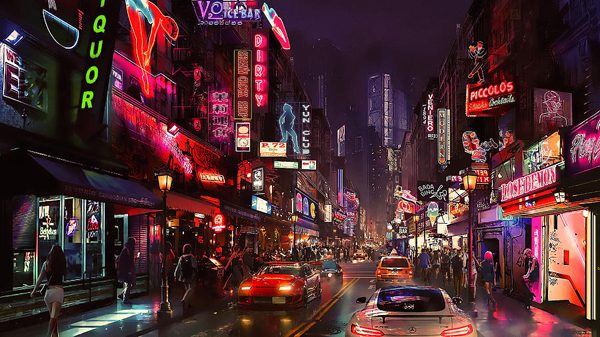

In [4]:
print(os.path.join(BASE_PATH, base_image_path))
display(Image(os.path.join(BASE_PATH, base_image_path)))

print('\n')

print(os.path.join(BASE_PATH, style_reference_image_path))
display(Image(os.path.join(BASE_PATH, style_reference_image_path)))

In [5]:
def preprocess_image(image_path):
    # From image to tensor
    # Let's load the image, convert it to an array, feed it into the VGG preprocessor, and transform it into a tensor 
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    print(f"Preprocess - Image shape: {img.shape}")
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    # From image to tensor
    x = x.reshape((img_nrows, img_ncols, 3))
    # RGB -> BGR 
    # Let's "remove" the zero-center by subtracting the mean values of the ImageNet dataset on which VGG is trained
    x[:, :, 0] += 103.939  # The average of colors in the Blue channel
    x[:, :, 1] += 116.779  # The average of colors in the Green channel
    x[:, :, 2] += 123.68   # The average of colors in the Red channel
    # preprocess_input has a default mode called 'coffee' that converts the color space from RGB to BGR
    # So then we need to revert back to RGB
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [6]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    # https://www.tensorflow.org/api_docs/python/tf/reshape
    # Thus, we calculate the transpose using TensorFlow
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# We maintain the style of the reference image in the generated one:
# the style loss is based on the Gram matrices of the feature maps of 
# the style image and the synthesized image
# https://www.mathsisfun.com/algebra/vectors-dot-product.html
# https://math.stackexchange.com/questions/805954/what-does-the-dot-product-of-two-vectors-represent
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    # "reduce_sum" calculates the sum of the elements of a tensor along a dimension or across all dimensions
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# Let's calculate the sum of squares of the differences between 
# the generated image and the reference image for the content
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# Total loss, to maintain the image 'locally more consistent'
def total_variation_loss(x):
    # We have 4 dimensions because we need to consider axis 0 
    # which represents the batch dimension. 
    # It calculates how much the pixels in one row differ from those in the next row
    # The indices are (as always): batch size, rows, columns, channels."
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    # It calculates how much the pixels in one column differ from those in the next column
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    # ASSUMPTION:
    # We raise this quantity to make the function differentiable. This allows us to use the function in SGD (Stochastic Gradient Descent). 
    # By changing 1.25, we change the 'weight' of this component in the final image."
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [7]:
# Let's build a VGG19 model with pre-trained weights on ImageNet and without the final fully connected (FC) layers
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# Let's build a dictionary of layers and their outputs
for layer in model.layers:
    print("{} -> {}".format(layer.name, layer.output))

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# This model returns the activation values for each layer in the VGG19
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

input_1 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
block1_conv1 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
block1_conv2 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")
block1_pool -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
block2_conv1 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
block2_conv2 -> KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32,

In [8]:
# List of layers to use for the style loss function
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss function
content_layer_name = "block5_conv2"


# Calculate the total error that will be used in gradient descent.
# The output is a number that is the sum of the content loss, style loss, and total variation loss
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )

    features = feature_extractor(input_tensor)

    # Let's initialize the cost to 0
    loss = tf.zeros(shape=())

    # Let's add the cost of the "content" image weighted by the content_weight
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Let's add the cost of the "style" image weighted by the style_weight
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Let's add the global loss weighted by total_variation_weight
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [9]:
# "Turn off" eager execution in TensorFlow to speed up operations
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    # GradientTape is used to optimize the computation of various w.r.t. gradients 
    # https://medium.com/analytics-vidhya/tf-gradienttape-explained-for-keras-users-cc3f06276f22

    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [10]:
for i in range(0, len(sources)):
    # Let's perform a "naive" gradient descent to minimize the cost.
    # The learning rate (LR) is unusually high: the weights are very small, they multiply values between 0 and 1, generating even smaller values.
    # We set it high to avoid very small numbers during gradient descent.
    optimizer = AdamW(weight_decay=1e-3, learning_rate=10.)

    base_image_path = sources[i]["subject"]
    style_reference_image_path = sources[i]["style"]
    dir_name = f"{os.path.splitext(base_image_path)[0]}_{os.path.splitext(style_reference_image_path)[0]}_{iterations}"

    weights_file = os.path.join(
        BASE_PATH,
        dir_name,
        f'{os.path.splitext(base_image_path)[0]}_weights.npy'
    )

    # If the directory to save the generated images does not exist, create it.
    # Location -> style_transfer/{SUBJECT}_{STYLE_REFERENCE}
    if os.path.exists(os.path.join(BASE_PATH, dir_name)) is False:
        os.mkdir(
            os.path.join(
                BASE_PATH,
                dir_name
            )
        )

    # # Let's check if the weights file exists
    # If it exists, we perform a number of "fake" trainings to bring us exactly to the saving condition 
    # in terms of the number of iterations of gradient descent.
    # if os.path.exists(weights_file):
    #     opt_weights = np.load(f"{weights_file}", allow_pickle=True)
    #     print("Loading Weights for optimizer...")
    #     grad_vars = feature_extractor.trainable_weights
    #     old_grads = [tf.zeros_like(w) for w in grad_vars]
    #     # Apply gradients which don't do nothing with SGD
    #     optimizer.apply_gradients(zip(old_grads, grad_vars))
    #     # Set the weights of the optimizer
    #     optimizer.set_weights(opt_weights)

    # The dimensions of the generated images.
    width, height = tf.keras.preprocessing.image.load_img(os.path.join(BASE_PATH, base_image_path)).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)

    base_image = preprocess_image(os.path.join(BASE_PATH, base_image_path))
    style_reference_image = preprocess_image(os.path.join(BASE_PATH, style_reference_image_path))
    combination_image = tf.Variable(preprocess_image(os.path.join(BASE_PATH, base_image_path)))

    # For each iteration, we calculate the error and the gradient,
    # apply the found gradients to the gradient descent, and every few iterations,
    # we deprocess the combination_image and save it.
    print(f"Image: {os.path.splitext(base_image_path)[0]}; Style {os.path.splitext(style_reference_image_path)[0]}")

    for o in range(iterations + 1):
        loss, grads = compute_loss_and_grads(
            combination_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, combination_image)])
        if o == 1 or o == 3 or o == 8 or o == 25 or o == 66:
            img = deprocess_image(combination_image.numpy())
            fname = os.path.splitext(base_image_path)[0] + "_at_iteration_%d.png" % o
            tf.keras.preprocessing.image.save_img(os.path.join('style_transfer_bk', dir_name, fname), img)
        if o % 50 == 0:
            print("\rIteration %d: loss=%.2f" % (o, loss), '- learning rate:', optimizer.learning_rate.numpy(), '            ', end='')
            if (o < 2000 and o % 100 == 0) or (o >=1000 and o % 250 == 0):
                if o > 0:
                    tf.keras.backend.set_value(optimizer.learning_rate, optimizer.learning_rate.numpy() * .75)
                print()
                img = deprocess_image(combination_image.numpy())
                fname = os.path.splitext(base_image_path)[0] + "_at_iteration_%d.png" % o
                tf.keras.preprocessing.image.save_img(os.path.join('style_transfer_bk', dir_name, fname), img)
    np.save(weights_file, optimizer.get_weights())

Preprocess - Image shape: (1, 400, 764, 3)
Preprocess - Image shape: (1, 400, 764, 3)
Preprocess - Image shape: (1, 400, 764, 3)
Image: forest; Style metropolis
Iteration 0: loss=400211.72 - learning rate: 10.0             
Iteration 100: loss=9352.07 - learning rate: 10.0             
Iteration 200: loss=9585.69 - learning rate: 7.5             
Iteration 300: loss=7054.75 - learning rate: 5.625             
Iteration 400: loss=6897.99 - learning rate: 4.21875             
Iteration 500: loss=6824.60 - learning rate: 3.1640625             
Iteration 600: loss=6817.18 - learning rate: 2.3730469             


c:\Users\reand\tf\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Forest at iteration 600:


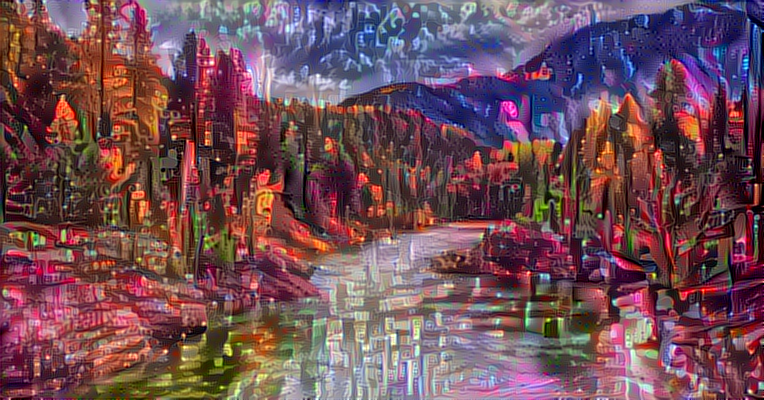

In [18]:
# The final image at iteration 600
print("Forest at iteration 600:" )
forest_at_iteration_600 = r"C:\Users\reand\Desktop\forest_at_iteration_600.png"
display(Image(filename=forest_at_iteration_600))
